In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# EDA
## Importing Libraries

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer, MinMaxScaler, StandardScaler, MaxAbsScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import loguniform, randint, uniform
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns
import re
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier


## Checking the data

In [3]:
train= pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [4]:
train.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


## Plotting the confusion matrix and heatmap

In [5]:
num_cols_tr=train.select_dtypes(include=['number'])

In [6]:
corr_mat=num_cols_tr.corr()
corr_mat

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,...,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
IsBetaUser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RealTimeProtectionState,NaN,1.000000,-0.901426,0.107907,-0.184396,-0.001299,-0.001035,0.010743,-0.001671,0.013603,...,0.010112,0.008421,-0.015123,0.007044,0.009187,0.003635,0.019879,-0.023005,-0.009479,0.049012
IsPassiveModeEnabled,NaN,-0.901426,1.000000,-0.111384,0.195344,0.023414,0.004929,-0.010327,-0.001968,-0.013213,...,-0.009343,-0.008979,0.017269,-0.007088,-0.005307,-0.000579,-0.016466,0.025863,0.007966,-0.041997
AntivirusConfigID,NaN,0.107907,-0.111384,1.000000,-0.647222,-0.115021,0.059230,0.008457,-0.000666,0.017477,...,-0.009623,-0.020802,-0.044251,0.023157,0.034506,0.033627,0.060264,-0.026385,-0.008294,0.118304
NumAntivirusProductsInstalled,NaN,-0.184396,0.195344,-0.647222,1.000000,0.273791,0.010237,-0.017957,0.003512,-0.042795,...,0.054231,0.047223,0.210308,-0.035076,-0.011100,-0.029814,-0.075055,0.008620,0.028845,-0.151375
NumAntivirusProductsEnabled,NaN,-0.001299,0.023414,-0.115021,0.273791,1.000000,-0.020977,-0.014795,0.006448,-0.022393,...,0.015469,0.003158,0.037019,-0.009299,0.000088,-0.005245,-0.018295,-0.009562,0.000937,-0.041547
HasTpm,NaN,-0.001035,0.004929,0.059230,0.010237,-0.020977,1.000000,0.007648,-0.005940,0.005161,...,-0.004301,-0.001458,0.035167,0.000676,0.011799,0.009900,0.013294,0.028136,-0.003924,0.007658
CountryID,NaN,0.010743,-0.010327,0.008457,-0.017957,-0.014795,0.007648,1.000000,-0.000624,0.597061,...,-0.018788,0.021881,-0.013022,-0.005375,0.004135,-0.008432,-0.008681,0.017307,-0.117528,0.004616
CityID,NaN,-0.001671,-0.001968,-0.000666,0.003512,0.006448,-0.005940,-0.000624,1.000000,-0.060922,...,-0.025710,0.019929,0.010010,-0.001436,-0.015534,-0.000909,-0.003993,0.004718,-0.052817,-0.004596
GeoRegionID,NaN,0.013603,-0.013213,0.017477,-0.042795,-0.022393,0.005161,0.597061,-0.060922,1.000000,...,-0.003138,0.004449,-0.067412,0.010703,0.023614,-0.002761,-0.009481,-0.002651,-0.022153,0.002802


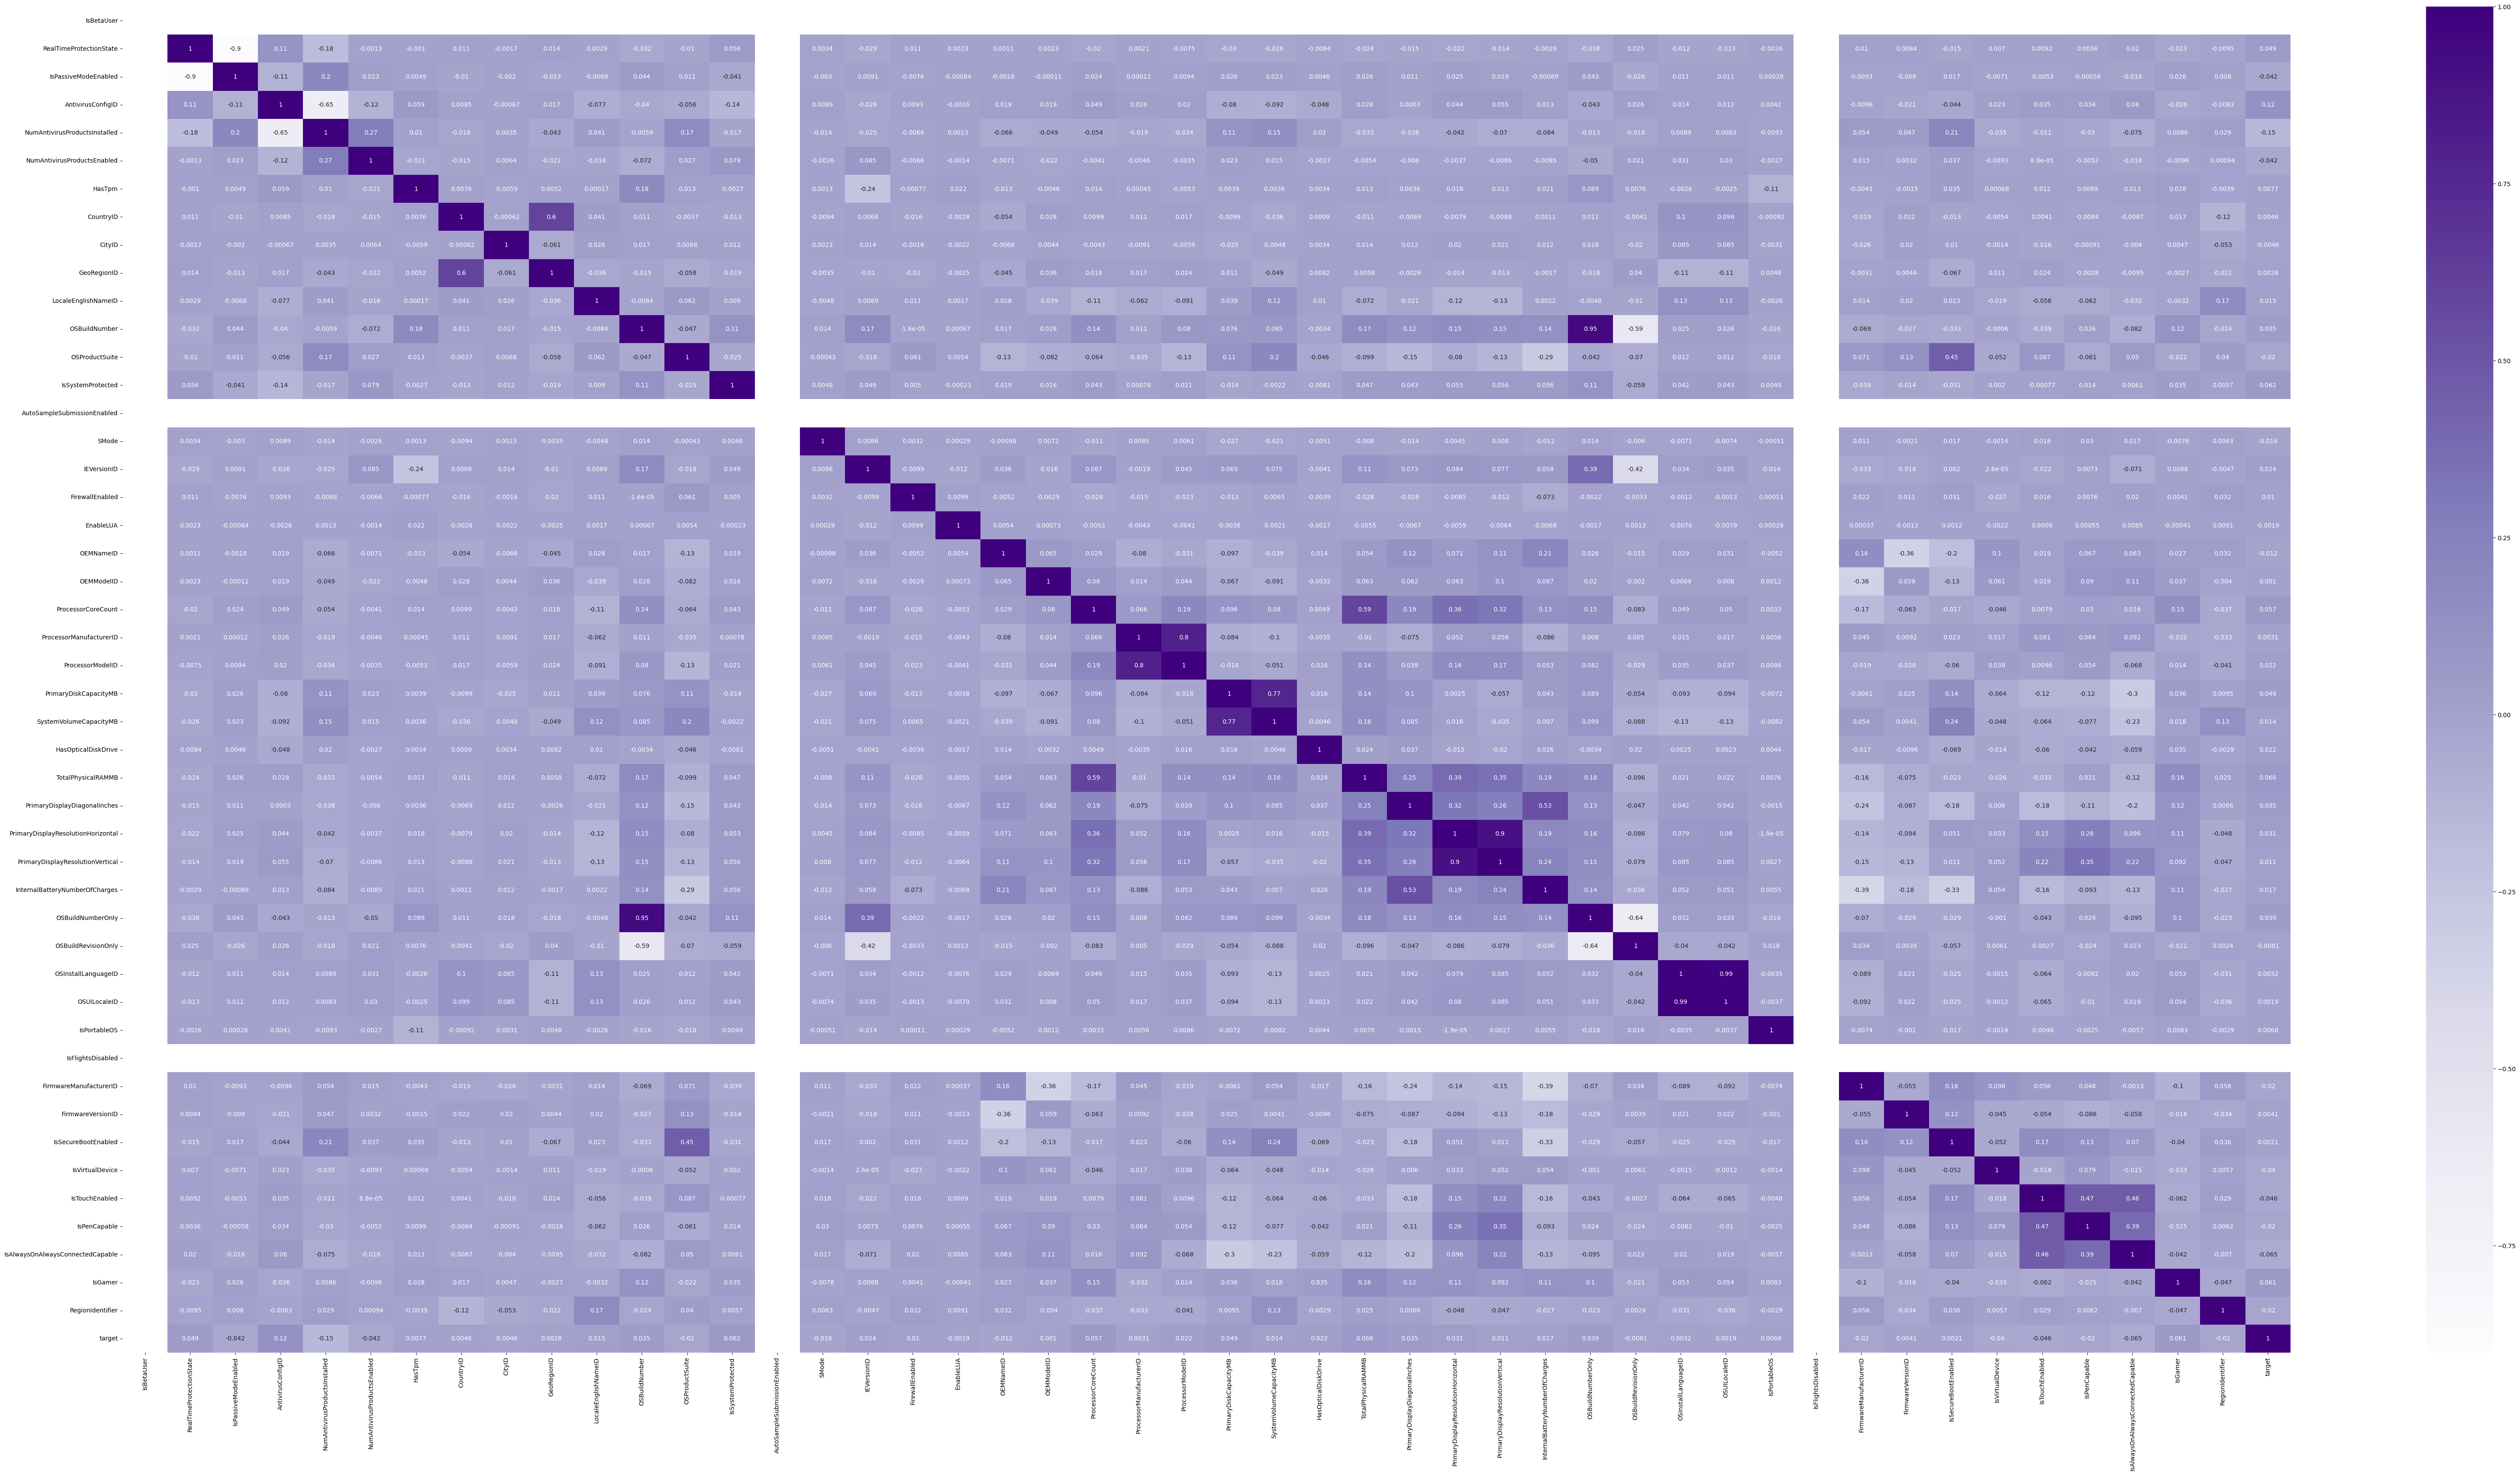

In [7]:
plt.figure(figsize=(80, 40))
sns.heatmap(corr_mat, annot=True, cmap='Purples')

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Some highly correlated pairs (ABS Value)
1. IsPassiveModeEnabled and RealTimeProtectionState (0.9)
2. OSBuildNumber and OSBuildNumberOnly (0.95)
3. OSUILocaleID and OSInstallLanguageID (0.99)
4. PrimaryDisplayResolutionHorizonatal and PrimaryDisplayResolutionVertical (0.9)
5. ProcessorManufacturerID and ProcessorModelID

## Some Redundant columns are as they have either NaN or only single value
1. AutoSampleSubmissionEnabled
2. IsFlightsDisabled
3. IsBetaUser

In [8]:
train_data=train.copy()
test_data=test.copy()
y=train_data['target']

## Checking the unique values in each column

In [9]:
unique_values = {col: train_data[col].unique() for col in train_data.columns}
for column, values in unique_values.items():
    print(f"\n{column}:")
    print(f"Number of unique values: {len(values)}")
    print("Unique values:")
    print(values)


MachineID:
Number of unique values: 99835
Unique values:
['f541bae429089117c4aac39c90dd3416' 'dc2b14d9ce3a0ce4050bb640190f2ca5'
 'fd20c5f010e9c5f91ad1c6b3e0da68a0' ... 'd6852dfff534e03d5ddfd3c7875ab072'
 '70a8dc682128c9ff78a3de5aea9dac74' 'ad9c385b53f2ca788933a39603b84eda']

ProductName:
Number of unique values: 2
Unique values:
['win8defender' 'mse']

EngineVersion:
Number of unique values: 37
Unique values:
['1.1.15200.1' '1.1.15100.1' '1.1.15000.2' '1.1.14800.3' '1.1.14901.4'
 '1.1.15300.6' '1.1.14700.5' '1.1.13504.0' '1.1.14104.0' '1.1.14306.0'
 '1.1.15300.5' '1.1.14600.4' '1.1.13701.0' '1.1.15000.1' '1.1.13202.0'
 '1.1.13303.0' '1.1.14500.5' '1.1.13601.0' '1.1.13704.0' '1.1.13407.0'
 '1.1.14003.0' '1.1.14202.0' '1.1.14405.2' '1.1.13000.0' '1.1.13804.0'
 '1.1.14500.2' '1.1.14800.1' '1.1.14305.0' '1.1.14901.3' '1.1.13103.0'
 '1.1.13903.0' '1.1.12805.0' '1.1.14700.4' '1.1.12902.0' '1.1.14700.3'
 '1.1.13802.0' '1.1.13803.0']

AppVersion:
Number of unique values: 69
Unique values:
['4

## Dropping the columns
1. MachineID has around 100000 unique values, which makes it redundant
2. ISBetaUser, AutoSampleSubmissionEnabled has only 1 value
3. IsFlightDisabled has 2 values, which is 0 and nan.
4. OSSkuFriendlyName has almost same values as OSEdition
5. The redundant and highly related columns from the confusion matrix

In [10]:
new_train_data=train_data.drop(columns=['MachineID','ProcessorModelID','PrimaryDisplayResolutionVertical','OSInstallLanguageID','OSBuildNumberOnly','RealTimeProtectionState', 'IsBetaUser','AutoSampleSubmissionEnabled','OSSkuFriendlyName','IsFlightsDisabled','target'])
new_test_data=test_data.drop(columns=['MachineID','ProcessorModelID','PrimaryDisplayResolutionVertical','OSInstallLanguageID','OSBuildNumberOnly','RealTimeProtectionState', 'IsBetaUser','AutoSampleSubmissionEnabled','OSSkuFriendlyName','IsFlightsDisabled'])

## Changing the outlier in the EnableLUA column to the mode

In [11]:
new_train_data['EnableLUA']=new_train_data['EnableLUA'].replace(48,np.nan)
new_train_data['EnableLUA']=new_train_data['EnableLUA'].replace(np.nan,1)
new_test_data['EnableLUA']=new_test_data['EnableLUA'].replace(48,np.nan)
new_test_data['EnableLUA']=new_test_data['EnableLUA'].replace(np.nan,1)

## Converting the column to numerical from scientific notation

In [12]:
new_train_data['InternalBatteryNumberOfCharges']=new_train_data['InternalBatteryNumberOfCharges'].apply(lambda x: '{:.0f}'.format(x))
new_test_data['InternalBatteryNumberOfCharges']=new_test_data['InternalBatteryNumberOfCharges'].apply(lambda x: '{:.0f}'.format(x))

This has too many unrealistic values, like 0 and 4294967295, which is taking around 85% of the data, so it is better to drop this column.

In [13]:
new_train_data=new_train_data.drop(columns=['InternalBatteryNumberOfCharges'])
new_test_data=new_test_data.drop(columns=['InternalBatteryNumberOfCharges'])

## Taking out categorical and numerical columns

In [14]:
cat_cols=new_train_data.select_dtypes(include=['object','category']).columns
num_cols=new_train_data.select_dtypes(include=['number']).columns

In [15]:
cat_cols,num_cols

(Index(['ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion',
        'PlatformType', 'Processor', 'OSVersion', 'OsPlatformSubRelease',
        'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily',
        'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole',
        'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition',
        'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState',
        'LicenseActivationChannel', 'FlightRing', 'DateAS', 'DateOS'],
       dtype='object'),
 Index(['IsPassiveModeEnabled', 'AntivirusConfigID',
        'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled',
        'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID',
        'OSBuildNumber', 'OSProductSuite', 'IsSystemProtected', 'SMode',
        'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID',
        'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID',
        'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB',
      

In [16]:
new_train_data[cat_cols]=new_train_data[cat_cols].replace(['Invalid','Unspecified', 'UNKNOWN','Unknown','NOT_SET','0','30','35'],np.nan)
new_test_data[cat_cols]=new_test_data[cat_cols].replace(['Invalid','Unspecified', 'UNKNOWN','Unknown','NOT_SET','0','30','35'],np.nan)

# Data Preprocessing

## Making pipelines

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [18]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()) 
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])

In [19]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

## Fitting the data

In [20]:
train_transformed = preprocessor.fit_transform(new_train_data)
test_transformed = preprocessor.transform(new_test_data)

## Making new test and train data, cleaned form of the previous version

In [21]:
train_cleaned = pd.DataFrame(train_transformed, columns=num_cols.tolist() + cat_cols.tolist())
test_cleaned = pd.DataFrame(test_transformed, columns=num_cols.tolist() + cat_cols.tolist())

In [22]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 64 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   IsPassiveModeEnabled                100000 non-null  float64
 1   AntivirusConfigID                   100000 non-null  float64
 2   NumAntivirusProductsInstalled       100000 non-null  float64
 3   NumAntivirusProductsEnabled         100000 non-null  float64
 4   HasTpm                              100000 non-null  float64
 5   CountryID                           100000 non-null  float64
 6   CityID                              100000 non-null  float64
 7   GeoRegionID                         100000 non-null  float64
 8   LocaleEnglishNameID                 100000 non-null  float64
 9   OSBuildNumber                       100000 non-null  float64
 10  OSProductSuite                      100000 non-null  float64
 11  IsSystemProtected          

# Training and Hypertuning Models

## Spliting the dataset

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [24]:
X_train,X_test, y_train, y_test=train_test_split(
    train_cleaned,y, test_size=0.2, random_state=42)

## SGD Classifier

In [25]:
sgdc=SGDClassifier(random_state=42)

In [26]:
param_grid_sgdc = {
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],  
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1], 
    'eta0': [0.001, 0.01, 0.1, 1], 
}

In [27]:
from sklearn.model_selection import RandomizedSearchCV
r_search_sgdc = RandomizedSearchCV(sgdc, param_grid_sgdc, cv=5, scoring='accuracy', n_jobs=-1)
r_search_sgdc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SGDClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'eta0': [0.001, 0.01, 0.1, 1],
                                        'loss': ['hinge', 'log_loss',
                                                 'modified_huber'],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   scoring='accuracy')

In [28]:
print("Best Accuracy:", r_search_sgdc.best_score_)

Best Accuracy: 0.5949625000000001


## Gradient Boosting Classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42,n_iter_no_change=10, tol=1e-4)

In [30]:
param_grid_gbc = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'max_depth': [3, 4, 5, 6,],  
    'min_samples_split': [2, 5, 10, 20]
}

In [31]:
r_search_gbc=RandomizedSearchCV(gbc, param_grid_gbc, n_iter=10, scoring='accuracy', cv=3, random_state=42, n_jobs=-1, verbose=2)
r_search_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=GradientBoostingClassifier(n_iter_no_change=10,
                                                        random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy', verbose=2)

In [32]:
print("Best Accuracy:", r_search_gbc.best_score_)

Best Accuracy: 0.6228749617566703


## Decision Tree Classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state=42)

In [34]:
param_grid_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],  
    'max_depth': [None, 10, 20, 30, 50],  
    'min_samples_split': [2, 5, 10, 20],  
    'min_samples_leaf': [1, 2, 5, 10],  }

In [35]:
r_search_dt = RandomizedSearchCV( dt, param_grid_dt, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)
r_search_dt.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, 10, 20, 30, 50],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, verbose=2)

In [36]:
print("Best Accuracy:", r_search_dt.best_score_)

Best Accuracy: 0.5959874889361078


## Checking all the scores

In [37]:
print("Best Accuracy SGD Classifier:", r_search_sgdc.best_score_)
print("Best Accuracy Gradient Boosting Classifier:", r_search_gbc.best_score_)
print("Best Accuracy Decision Tree:", r_search_dt.best_score_)

Best Accuracy SGD Classifier: 0.5949625000000001
Best Accuracy Gradient Boosting Classifier: 0.6228749617566703
Best Accuracy Decision Tree: 0.5959874889361078


## Making Confusion Matrix and Classification reports

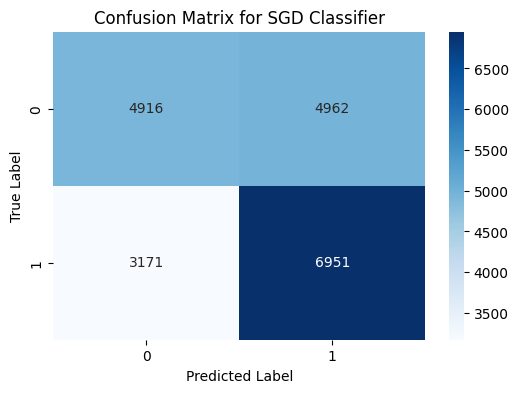

In [38]:
from sklearn.metrics import confusion_matrix
y_pred_sgd=r_search_sgdc.predict(X_test)
cm_sgd=confusion_matrix(y_test, y_pred_sgd)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SGD Classifier")
plt.show()

In [39]:
from sklearn.metrics import classification_report
report_sgd = classification_report(y_test, y_pred_sgd)
print(report_sgd)

              precision    recall  f1-score   support

           0       0.61      0.50      0.55      9878
           1       0.58      0.69      0.63     10122

    accuracy                           0.59     20000
   macro avg       0.60      0.59      0.59     20000
weighted avg       0.60      0.59      0.59     20000



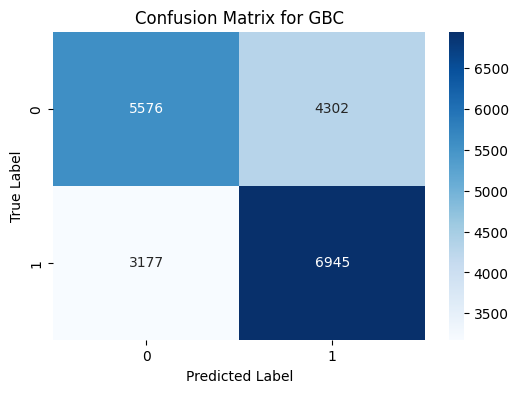

In [40]:
y_pred_gbc=r_search_gbc.predict(X_test)
cm_gbc=confusion_matrix(y_test, y_pred_gbc)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gbc, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for GBC")
plt.show()

In [41]:
report_gbc = classification_report(y_test, y_pred_gbc)
print(report_gbc)

              precision    recall  f1-score   support

           0       0.64      0.56      0.60      9878
           1       0.62      0.69      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.62     20000
weighted avg       0.63      0.63      0.62     20000



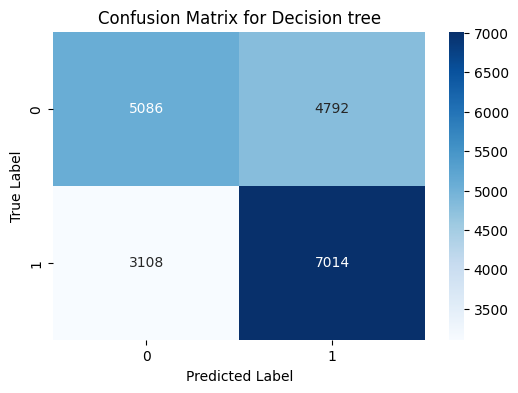

In [42]:
y_pred_dt=r_search_dt.predict(X_test)
cm_dt=confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Decision tree")
plt.show()

In [43]:
report_dt = classification_report(y_test, y_pred_dt)
print(report_dt)

              precision    recall  f1-score   support

           0       0.62      0.51      0.56      9878
           1       0.59      0.69      0.64     10122

    accuracy                           0.60     20000
   macro avg       0.61      0.60      0.60     20000
weighted avg       0.61      0.60      0.60     20000



# Submitting the file

As the best model is Gradient Boosting Classifier, we'll submit that

## Our model (Gradient Boosting classifier) was predicting the values with an accuracy of around 63%

In [44]:
y_pred_final = r_search_gbc.predict(test_cleaned)
sample = pd.read_csv("/kaggle/input/System-Threat-Forecaster/sample_submission.csv")
sample['target'] = y_pred_final
sample.to_csv("submission.csv",index=False)